# Skill Check 4

You will optimize the complexity of regression models in terms of information criteria and smoothness. In problem **1**, you will see the trade-off between model performance and model complexity. In problems **2** and **3**, ridge regression will be covered along with hyperparameter tuning.

The block below defines the necessary variables and shows a plot of the portion of the IR spectrum that you will work with in this assignment:

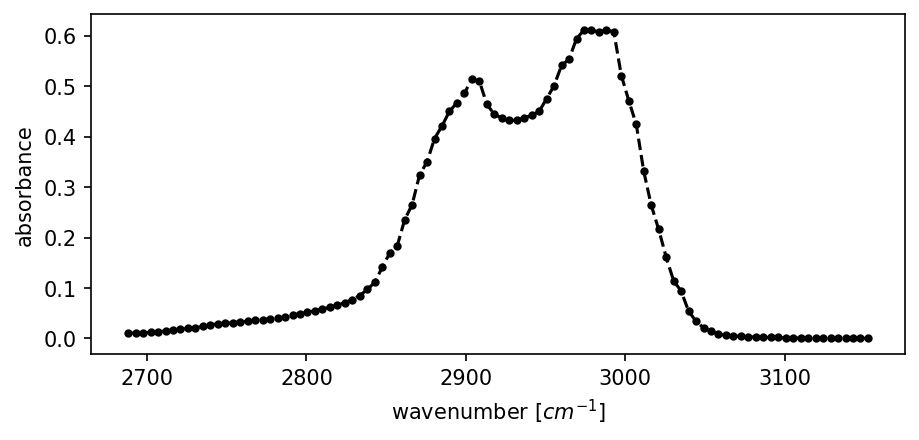

In [1]:
import pandas as pd
import numpy as np
import pylab as plt

df = pd.read_csv('ethanol_IR.csv')
x_peak = df['wavenumber [cm^-1]'].values[475:575].reshape(-1)
y_peak = df['absorbance'].values[475:575]

fig, ax = plt.subplots(figsize = (7, 3), dpi = 150)
ax.plot(x_peak, y_peak, '--k', marker = '.')
ax.set_xlabel('wavenumber [$cm^{-1}$]')
ax.set_ylabel('absorbance');

## 1. Bayesian Information Criteria (40 pts)

Given normally distributed prediction errors, the **Bayesian Information Criteria** (BIC) is computed as:

$\mathrm{BIC}=n\times ln\left(\sigma_e^2\right)+k\times ln\left(n\right)$

where $n$ is the number of data points, $\sigma_e$ is the standard deviation of the error, and $k$ is the number of parameters. You will revisit the evenly spaced Gaussians features from the last module and see how the complexity varies with respect to the number of Gaussians. The positions and widths of Gaussians will be known values in which case their weights are the only parameters to be optimized (i.e. $k$ = the number of Gaussians).

Let's first recreate the `gaussian_features` function. It generates `N` evenly-spaced Gaussians with a fixed width `sigma` in a given range of `x`. The return value `features` should be an array (or matrix) with dimensions of (length of `x` X `N`). The default value of `sigma` is set to 25 for you. (15 pts)

In [2]:
def gaussian_features(x, N, sigma = 25):
########################################
# Start your code here
    features = np.zeros((len(x), N))
    x_mean = np.linspace(x.min(), x.max(), N)
    
    for i, mean in enumerate(x_mean):
        features[:, i] = np.exp( -(x - mean)**2 / 2 / sigma**2 )
########################################
    return features

In [3]:
assert gaussian_features(x_peak, 8, sigma = 25).shape == (100, 8)
assert np.isclose(np.linalg.norm(gaussian_features(y_peak, 30, 25)), 54.768167597688894)

Create a function `BIC` that returns the BIC for a given true value `y` and predicted value `y_hat`. `BIC` takes three arguments: (10 pts)

- `y`: true value (1-D numpy array)
- `y_hat`: predicted value (1-D numpy array)
- `k`: the number of parameters (float)

In [4]:
def BIC(y, y_hat, k):
########################################
# Start your code here
    err = y - y_hat
    sigma = np.std(np.real(err))
    n = len(y)
    bic = n*np.log(sigma**2) + k*np.log(n)
########################################
    return bic

In [5]:
assert np.isclose(BIC(x_peak, y_peak, 10), 1027.5392342003545), "wrong BIC"

You will compare the BIC's with respect to the number of Gaussians `N`. The following is the expected training procedure for each `N`:

- Declare a LinearRegression() model
- Create Gaussian features for `x_peak`
- Train a LinearRegression() model with created Gaussian features
- Get predictions from created Gaussian features
- Compute the BIC

Finally, you will find the optimum number of Gaussians that gives you the lowest BIC. Determine the optimum `N` out of [2, 4, 8, 16, 32, 64]. Save the BICs for each `N` in the **list** `BICs` (5 pts) and save the optimum `N` as `opt_N` (10 pts).

***Hint***: Be careful of intercept fitting. We want the number of parameters to be identical to the number of Gaussians. Think how the intercept fitting (or changing the `fit_intercept` argument) will affect the number of parameters.

In [6]:
N = [2, 4, 8, 16, 32, 64]

In [7]:
########################################
# Start your code here
from sklearn.linear_model import LinearRegression

lr = LinearRegression(fit_intercept = False)

BICs = []
for n in N:
    features = gaussian_features(x_peak, n)
    lr.fit(features, y_peak)
    yhat = lr.predict(features)
    BICs.append(BIC(y_peak, yhat, n))
    
opt_N = N[BICs.index(min(BICs))]
########################################

In [8]:
assert type(BICs) == list, "BICs is not a list"
assert np.isclose(np.linalg.norm(BICs), 1615.8365512907048), "BICs not correct"

In [9]:
assert np.isclose(x_peak[N.index(opt_N)], 2702.1888329999997), "opt_N not correct"

## 2. Hyperparameter Tuning (30 pts)

In this problem, you will tune one hyperparameter (`alpha`) of a kernel ridge regression model using hold-out.

Reshape `x_peak` and `y_peak` into 100 x 1 2-D numpy array. (15 pts)

In [10]:
########################################
# Start your code here
x_peak = x_peak.reshape(-1, 1)
y_peak = y_peak.reshape(-1, 1)
########################################

In [11]:
assert x_peak.shape[0] * y_peak.shape[1] == 100

We have imported `KernelRidge` and `train_test_split` for you. Split `x_peak` and `y_peak` to `x_train`, `x_test`, `y_train`, and `y_test` using `train_test_split`. The `test_size` and `random_state` should be `0.3` and `42`, respectively. (10 pts)

***Note***: If you fail to set a proper `random_state`, you won't pass any assertion tests for the following problems.

In [12]:
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import train_test_split

In [13]:
########################################
# Start your code here
x_train, x_test, y_train, y_test = train_test_split(x_peak, y_peak, random_state = 42, test_size = 0.3, )
########################################

In [14]:
assert np.isclose(np.linalg.norm(x_train) * np.linalg.norm(y_test), 30091.14092468128), "wrong data split"

You will find the optimum `alpha` out of [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]. The following is the expected training steps for each `alpha`:

- Declare a `KernelRidge(kernel = 'rbf', gamma = 0.005)` model
- Train the model on the training set
- Get $\mathrm{r^2}$ on the test set

The optimum `alpha` is the one that gives you the highest $\mathrm{r^2}$ on the test set. Report the optimum as `opt_alpha` and the highest $\mathrm{r^2}$ as `opt_r2`. (5 pts)

In [15]:
alphas = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]

In [16]:
########################################
# Start your code here
opt_r2 = 0

for alpha in alphas:
    krr = KernelRidge(kernel = 'rbf', gamma = 0.005, alpha = alpha)
    krr.fit(x_train, y_train)
    if opt_r2 < krr.score(x_test, y_test):
        opt_r2 = krr.score(x_test, y_test)
        opt_alpha = alpha
########################################

In [17]:
assert np.isclose(opt_r2**2 * opt_alpha**3, 0.000994900259406524)

## 3. GridSearchCV (30 pts)

You will optimize multiple hyperparameters in a kernel ridge regression using `GridSearchCV` in this case.

Let's first import `GridSearchCV`. (15 pts)

In [18]:
########################################
# Start your code here
from sklearn.model_selection import GridSearchCV
########################################

In [19]:
assert GridSearchCV.__init__

Unlike `train_test_split`, `GridSearchCV` does not shuffle the data by default even though it actually supports k-fold cross validation. The impact of shuffling be covered in the homework. For now, we will shuffle `x_peak` and `y_peak` for you before using `GridSearchCV`.

In [20]:
from sklearn.utils import shuffle

x_shuffle, y_shuffle = shuffle(x_peak, y_peak, random_state = 3)

You will the find the best hyperparameter combination of `alpha` and `gamma`. Below we have provided the candidates of `alpha` and `sigma` (where $\gamma = \frac{1}{2\sigma^2}$). Create a parameter dictionary `param_grid` that will be input to a `GridSearchCV`. (10 pts)

**Hint:** Remember that the dictionary keys must be identical to the keyword arguments of the model, so you cannot use `sigma` directly.

In [21]:
alphas = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]
sigmas = [100, 150, 200, 250, 300, 350, 400, 450, 500]

In [22]:
########################################
# Start your code here
param_grid = {'alpha': np.array(alphas), 'gamma': 1 / 2 / np.array(sigmas)**2}
########################################

In [23]:
assert type(param_grid) == dict, "param_grid is not a dictionary"
assert set(param_grid.keys()) == {'alpha', 'gamma'}, "wrong param_grid"

Using `GridSearchCV` and `KernelRidge(kernel = 'rbf')`, find the optimum `alpha` and `gamma`. You need to use 5-fold cross validation during hyperparameter tuning. Report the optimum `alpha` as `alpha_opt` and the optimum `gamma` as `gamma_opt`. (5 pts)

In [24]:
########################################
# Start your code here
krr = KernelRidge(kernel = 'rbf')
krr_search = GridSearchCV(krr, param_grid, cv = 5)
krr_search.fit(x_shuffle, y_shuffle)

alpha_opt = krr_search.best_estimator_.alpha
gamma_opt = krr_search.best_estimator_.gamma
########################################

In [25]:
assert np.isclose(np.log10(alpha_opt) * np.log10(gamma_opt), 25.806179973983888)